In [1]:
import os
import sys
spark_home = '/usr/lib/spark'
os.environ['SPARK_HOME']= spark_home
os.environ['PYLIB']=os.environ['SPARK_HOME']+'/python/lib'
sys.path.insert(0,os.environ['PYLIB']+'/py4j-0.10.7-src.zip')
sys.path.insert(1,os.environ['PYLIB']+'/pyspark.zip')

In [2]:
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np

In [3]:
spark = SparkSession.builder.appName('BikeShareLinearRegression') \
.config('spark.warehouse.dir','/apps/hive/warehouse') \
.config('spark.driver.memory', '4G') \
.config('spark.sql.shuffle.partitions', 4) \
.enableHiveSupport().getOrCreate()

In [4]:
# Having set the driver and driver options we should have spark representing spark session 
# available straight away
spark.version

'2.3.1'

In [5]:
sc = spark.sparkContext

In [6]:
sc.setLogLevel('ERROR')

In [7]:
from pyspark.ml.feature  import VectorAssembler, VectorIndexer, OneHotEncoderEstimator
from pyspark.sql.types import DataType
from pyspark.sql import DataFrame
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.regression import LinearRegression, LinearRegressionModel, GeneralizedLinearRegression
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import PolynomialExpansion

In [8]:
#  load the bike sharing dataset
#  the independent variables are dteday, season , year, month, hour, holiday, weekday, 
#  workingday, normalized temperature, apparent normalized temperature, normalized humidity, windspeed
#  the value we are intersted in predicting is cnt - the number of bike rentals for that hour
fileloc = "D:/ufdata/bikesharing/hour.csv"
df = spark.read.format("csv").option("header", "true").load( fileloc)

In [9]:
df.registerTempTable("BikeSharing")
print(df.count())
spark.sql("SELECT * FROM BikeSharing").show()

17379
+-------+----------+------+---+----+---+-------+-------+----------+----------+----+------+----+---------+------+----------+---+
|instant|    dteday|season| yr|mnth| hr|holiday|weekday|workingday|weathersit|temp| atemp| hum|windspeed|casual|registered|cnt|
+-------+----------+------+---+----+---+-------+-------+----------+----------+----+------+----+---------+------+----------+---+
|      1|2011-01-01|     1|  0|   1|  0|      0|      6|         0|         1|0.24|0.2879|0.81|        0|     3|        13| 16|
|      2|2011-01-01|     1|  0|   1|  1|      0|      6|         0|         1|0.22|0.2727| 0.8|        0|     8|        32| 40|
|      3|2011-01-01|     1|  0|   1|  2|      0|      6|         0|         1|0.22|0.2727| 0.8|        0|     5|        27| 32|
|      4|2011-01-01|     1|  0|   1|  3|      0|      6|         0|         1|0.24|0.2879|0.75|        0|     3|        10| 13|
|      5|2011-01-01|     1|  0|   1|  4|      0|      6|         0|         1|0.24|0.2879|0.75|   

In [10]:
# drop record id, date, casual and registered columns
df1 = df.drop("instant").drop("dteday").drop("casual").drop("registered")

In [11]:
#  convert to double: season,yr,mnth,hr,holiday,weekday,workingday,weathersit,
#  temp,atemp,hum,windspeed,casual,registered,cnt
df2 = df1.withColumn("season", df1["season"].cast("double")) \
.withColumn("yr", df1["yr"].cast("double")) \
.withColumn("mnth", df1["mnth"].cast("double")) \
.withColumn("hr", df1["hr"].cast("double")) \
.withColumn("holiday", df1["holiday"].cast("double")) \
.withColumn("weekday", df1["weekday"].cast("double")) \
.withColumn("workingday", df1["workingday"].cast("double")) \
.withColumn("weathersit", df1["weathersit"].cast("double")) \
.withColumn("temp", df1["temp"].cast("double")) \
.withColumn("atemp", df1["atemp"].cast("double")) \
.withColumn("hum", df1["hum"].cast("double")) \
.withColumn("windspeed", df1["windspeed"].cast("double")) \
.withColumn("label", df1["cnt"].cast("double")) \
.drop("cnt")

In [12]:
windHist = df2.select("windspeed").toPandas()

In [13]:
windHist[:10]

,windspeed
0,0.0000
1,0.0000
2,0.0000
3,0.0000
4,0.0000
5,0.0896
6,0.0000
7,0.0000
8,0.0000
9,0.0000


In [14]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


(array([2.180e+03, 6.475e+03, 4.465e+03, 2.458e+03, 1.137e+03, 4.340e+02,
        1.670e+02, 4.800e+01, 9.000e+00, 6.000e+00]),
 array([0.     , 0.08507, 0.17014, 0.25521, 0.34028, 0.42535, 0.51042,
        0.59549, 0.68056, 0.76563, 0.8507 ]),
 <a list of 10 Patch objects>)

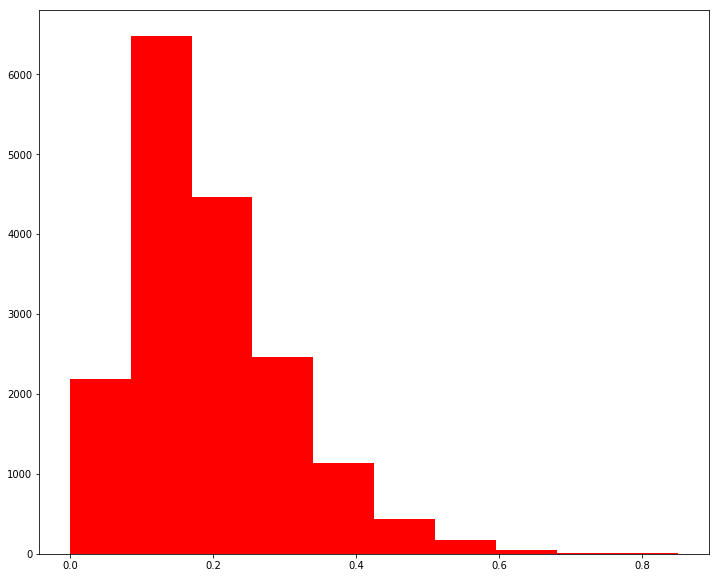

In [15]:
import matplotlib as mpl
from matplotlib import pyplot as plt
fig = plt.figure()
fig.set_size_inches(12, 10)
plt.hist(windHist.ix[:, 0], bins=10, color='r')

In [16]:
encoder = OneHotEncoderEstimator().setInputCols(
    ["season", "yr", "mnth", "hr", "holiday","weekday", "workingday", "weathersit"]).setOutputCols(
    ["seasonVec", "yrVec", "mnthVec", "hrVec", "holidayVec","weekdayVec", "workingdayVec", "weathersitVec"])

In [17]:
ohemodel = encoder.fit(df2)
oheEncoded = ohemodel.transform(df2)
df3 = oheEncoded.drop("season", "yr", "mnth", "hr", "holiday", "weekday", "workingday", "weathersit")
featureCols = df3.drop("label").columns
print(featureCols)

['temp', 'atemp', 'hum', 'windspeed', 'holidayVec', 'workingdayVec', 'mnthVec', 'weekdayVec', 'weathersitVec', 'yrVec', 'seasonVec', 'hrVec']


In [18]:
vectorAssembler = VectorAssembler().setInputCols(featureCols).setOutputCol("features")

In [19]:
lr = LinearRegression() \
.setFeaturesCol("features") \
.setLabelCol("label") \
.setRegParam(0.1) \
.setElasticNetParam(1.0) \
.setMaxIter(20)

In [20]:
pipeline = Pipeline().setStages([vectorAssembler, lr])

In [21]:
training, test = df3.randomSplit([0.8, 0.2], seed = 12345)

In [22]:
model = pipeline.fit(training)

In [23]:
fullPredictions = model.transform(test).cache()
predictions = fullPredictions.select("prediction").rdd.map(lambda x: x[0])
labels = fullPredictions.select("label").rdd.map(lambda x: x[0])
regMetrics = RegressionMetrics(predictions.zip(labels))
RMSE = regMetrics.rootMeanSquaredError
print('Root Mean Squared Error: ', RMSE)
r2_cod = regMetrics.r2
print('Cofficient of determiniation: ', r2_cod)

Root Mean Squared Error:  99.53294637804589
Cofficient of determiniation:  0.6863790488651046


In [24]:
lr_grid = LinearRegression()
paramGrid = ParamGridBuilder().addGrid(lr_grid.regParam, [0.1, 0.01, 0.00]) \
.addGrid(lr_grid.fitIntercept, [True, False]) \
.addGrid(lr_grid.elasticNetParam, [0.0, 0.25, 0.5, 0.75, 1.0])\
.addGrid(lr_grid.tol, [0.01, 0.001, 0.0001]) \
.build()
lr_grid.setMaxIter(1000)
pipelineGrid = Pipeline().setStages([vectorAssembler, lr_grid])

In [25]:
trainValidationSplit = TrainValidationSplit() \
.setEstimator(pipelineGrid) \
.setEvaluator(RegressionEvaluator()) \
.setEstimatorParamMaps(paramGrid) \
.setTrainRatio(0.8)

In [26]:
linModelPipeline = trainValidationSplit.fit(training)
gridPredictions = linModelPipeline.transform(test).select("label", "prediction")
r2lmp = RegressionMetrics(gridPredictions.rdd.map(lambda x: (x[1], x[0])))
print(r2lmp.rootMeanSquaredError)
print(r2lmp.r2)

99.64330173587297
0.6856832201970349


In [27]:
bestPipelineModel = linModelPipeline.bestModel
blinModel = bestPipelineModel.stages[1]
blinModel.extractParamMap()
print(blinModel.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2) (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty (default: 0.0, current: 0.25)
epsilon: The shape parameter to control the amount of robustness. Must be > 1.0. (default: 1.35)
featuresCol: features column name (default: features)
fitIntercept: whether to fit an intercept term (default: True, current: False)
labelCol: label column name (default: label)
loss: The loss function to be optimized. Supported options: squaredError, huber. (Default squaredError) (default: squaredError)
maxIter: maximum number of iterations (>= 0) (default: 100, current: 1000)
predictionCol: prediction column name (default: prediction)
regParam: regularization parameter (>= 0) (default: 0.0, current: 0.01)
solver: The solver algorithm for optimization. Supported options: auto, normal, l-bfgs. (Default auto) (default: auto)
standardization: wheth

In [30]:
crossval = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, numFolds=3, 
                          evaluator=RegressionEvaluator())

In [31]:
cvModel = crossval.fit(training)

In [32]:
cv_predictions = cvModel.transform(test)

In [35]:
cvPredictions = cvModel.transform(test).select("label", "prediction")
r2cvm = RegressionMetrics(cvPredictions.rdd.map(lambda x: (x[1], x[0])))
print(r2cvm.rootMeanSquaredError)
print(r2cvm.r2)

99.53294637804589
0.6863790488651046


In [38]:
cvModel.extractParamMap()

{Param(parent='CrossValidatorModel_4bd9b92ba7cdb9137783', name='seed', doc='random seed.'): 1421955268366911044,
 Param(parent='CrossValidatorModel_4bd9b92ba7cdb9137783', name='estimator', doc='estimator to be cross-validated'): Pipeline_4f6a8e4f5a27838fb8f0,
 Param(parent='CrossValidatorModel_4bd9b92ba7cdb9137783', name='estimatorParamMaps', doc='estimator param maps'): [{Param(parent='LinearRegression_41f48c4c0ff297f2d893', name='regParam', doc='regularization parameter (>= 0).'): 0.1,
   Param(parent='LinearRegression_41f48c4c0ff297f2d893', name='fitIntercept', doc='whether to fit an intercept term.'): True,
   Param(parent='LinearRegression_41f48c4c0ff297f2d893', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0,
   Param(parent='LinearRegression_41f48c4c0ff297f2d893', name='tol', doc='the convergence tolerance for iterative algorithms (>= 0).'): 0.01},
  {Param(pare

In [40]:
print(cvModel.explainParams())

estimator: estimator to be cross-validated (current: Pipeline_4f6a8e4f5a27838fb8f0)
estimatorParamMaps: estimator param maps (current: [{Param(parent='LinearRegression_41f48c4c0ff297f2d893', name='regParam', doc='regularization parameter (>= 0).'): 0.1, Param(parent='LinearRegression_41f48c4c0ff297f2d893', name='fitIntercept', doc='whether to fit an intercept term.'): True, Param(parent='LinearRegression_41f48c4c0ff297f2d893', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0, Param(parent='LinearRegression_41f48c4c0ff297f2d893', name='tol', doc='the convergence tolerance for iterative algorithms (>= 0).'): 0.01}, {Param(parent='LinearRegression_41f48c4c0ff297f2d893', name='regParam', doc='regularization parameter (>= 0).'): 0.1, Param(parent='LinearRegression_41f48c4c0ff297f2d893', name='fitIntercept', doc='whether to fit an intercept term.'): True, Param(parent='Linear